# PoC load forecast data

In [1]:
import xarray as xr
from datetime import datetime, timedelta
from dask.distributed import Client

In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit=500e6)
client

Client Scheduler: tcp://127.0.0.1:39363 Dashboard: /binder/jupyter/user/willirath-nia-p--low-latitutdes-o3qoox2o//proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 2.00 GB


In [3]:
def get_latest_forecast_url(
    url=(
        "https://thredds-jumbo.unidata.ucar.edu/thredds/"
        "dodsC/grib/NCEP/GFS/Global_onedeg/"
        "GFS_Global_onedeg_{time_stamp}.grib2"
        )
):
    now = datetime.now()
    today = datetime(now.year, now.month, now.day)
    for nback in range(8):
        date = (today + timedelta(days=1)) - nback * timedelta(hours=6)
        time_stamp = date.strftime("%Y%m%d_%H%M")
        try_url = url.format(time_stamp=time_stamp)
        try:
            ds = xr.open_dataset(try_url)
            return try_url
        except OSError as e:
            pass

In [4]:
latest_forecast_url = get_latest_forecast_url()
print(f"Using: {latest_forecast_url}")

Using: https://thredds-jumbo.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_20200805_0000.grib2


In [6]:
ds = xr.open_dataset(
    latest_forecast_url,
    chunks={"time2": 4, "height_above_ground4": 1}
)
ds

<xarray.Dataset>
Dimensions:                                                                     (altitude_above_msl: 3, altitude_above_msl1: 1, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 3, height_above_ground3: 1, height_above_ground4: 7, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, hybrid: 1, isobaric: 31, isobaric1: 29, isobaric2: 19, isobaric3: 1, isobaric4: 21, isobaric5: 24, isobaric6: 34, isobaric7: 22, lat: 181, lon: 360, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 2, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 1, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 128, time1: 128, time2: 129, time3: 254, time3_bounds_1: 2, time_bounds_1: 2)
Coordinates:
  * lat                                                                         (lat) float32 90.0 ... -90.0
  * lon                                                                         (lon) float32 0.0 ... 359.0
    reftime                                                                     datetime64[ns] ...
  * time                                                                        (time) datetime64[ns] 2020-08-05T03:00:00 ... 2020-08-21
  * time1                                                                       (time1) datetime64[ns] 2020-08-05T03:00:00 ... 2020-08-21
  * time2                                                                       (time2) datetime64[ns] 2020-08-05 ... 2020-08-21
  * time3                                                                       (time3) datetime64[ns] 2020-08-05T03:00:00 ... 2020-08-21
  * isobaric                                                                    (isobaric) float32 100.0 ... 100000.0
  * height_above_ground                                                         (height_above_ground) float32 2.0
  * sigma                                                                       (sigma) float32 0.995
  * isobaric1                                                                   (isobaric1) float32 40.0 ... 100000.0
  * isobaric2                                                                   (isobaric2) float32 10000.0 ... 100000.0
  * isobaric3                                                                   (isobaric3) float32 50000.0
  * height_above_ground1                                                        (height_above_ground1) float32 2.0 80.0
  * isobaric4                                                                   (isobaric4) float32 10000.0 ... 100000.0
  * altitude_above_msl                                                          (altitude_above_msl) float32 1829.0 ... 3658.0
  * pressure_difference_layer                                                   (pressure_difference_layer) float32 12750.0
  * pressure_difference_layer1                                                  (pressure_difference_layer1) float32 9000.0 12750.0
  * sigma_layer                                                                 (sigma_layer) float32 0.58000004 ... 0.83000004
  * height_above_ground2                                                        (height_above_ground2) float32 2.0 ... 100.0
  * isobaric5                                                                   (isobaric5) float32 40.0 ... 100000.0
  * potential_vorticity_surface                                                 (potential_vorticity_surface) float32 -2e-06 2e-06
  * height_above_ground_layer                                                   (height_above_ground_layer) float32 1500.0
  * depth_below_surface_layer                                                   (depth_below_surface_layer) float32 0.05 ... 1.5
  * pressure_difference_layer2                                   

In [7]:
sea_mask = (
    ds["Land_cover_0__sea_1__land_surface"] == 0
).isel(time2=0, drop=True)

In [8]:
U = ds["u-component_of_wind_height_above_ground"].sel(height_above_ground4=10, method="nearest")
U = U.where(sea_mask)
U = U.drop(["reftime", "height_above_ground4"])

V = ds["v-component_of_wind_height_above_ground"].sel(height_above_ground4=10, method="nearest")
V = V.where(sea_mask)
V = V.drop(["reftime", "height_above_ground4"])

speed = (U ** 2 + V ** 2)

In [9]:
speed

,Array,Chunk
Bytes,33.62 MB,1.04 MB
Shape,"(129, 181, 360)","(4, 181, 360)"
Count,763 Tasks,33 Chunks
Type,float32,numpy.ndarray


In [10]:
%time speed = speed.compute()

CPU times: user 2.3 s, sys: 266 ms, total: 2.57 s
Wall time: 12.2 s


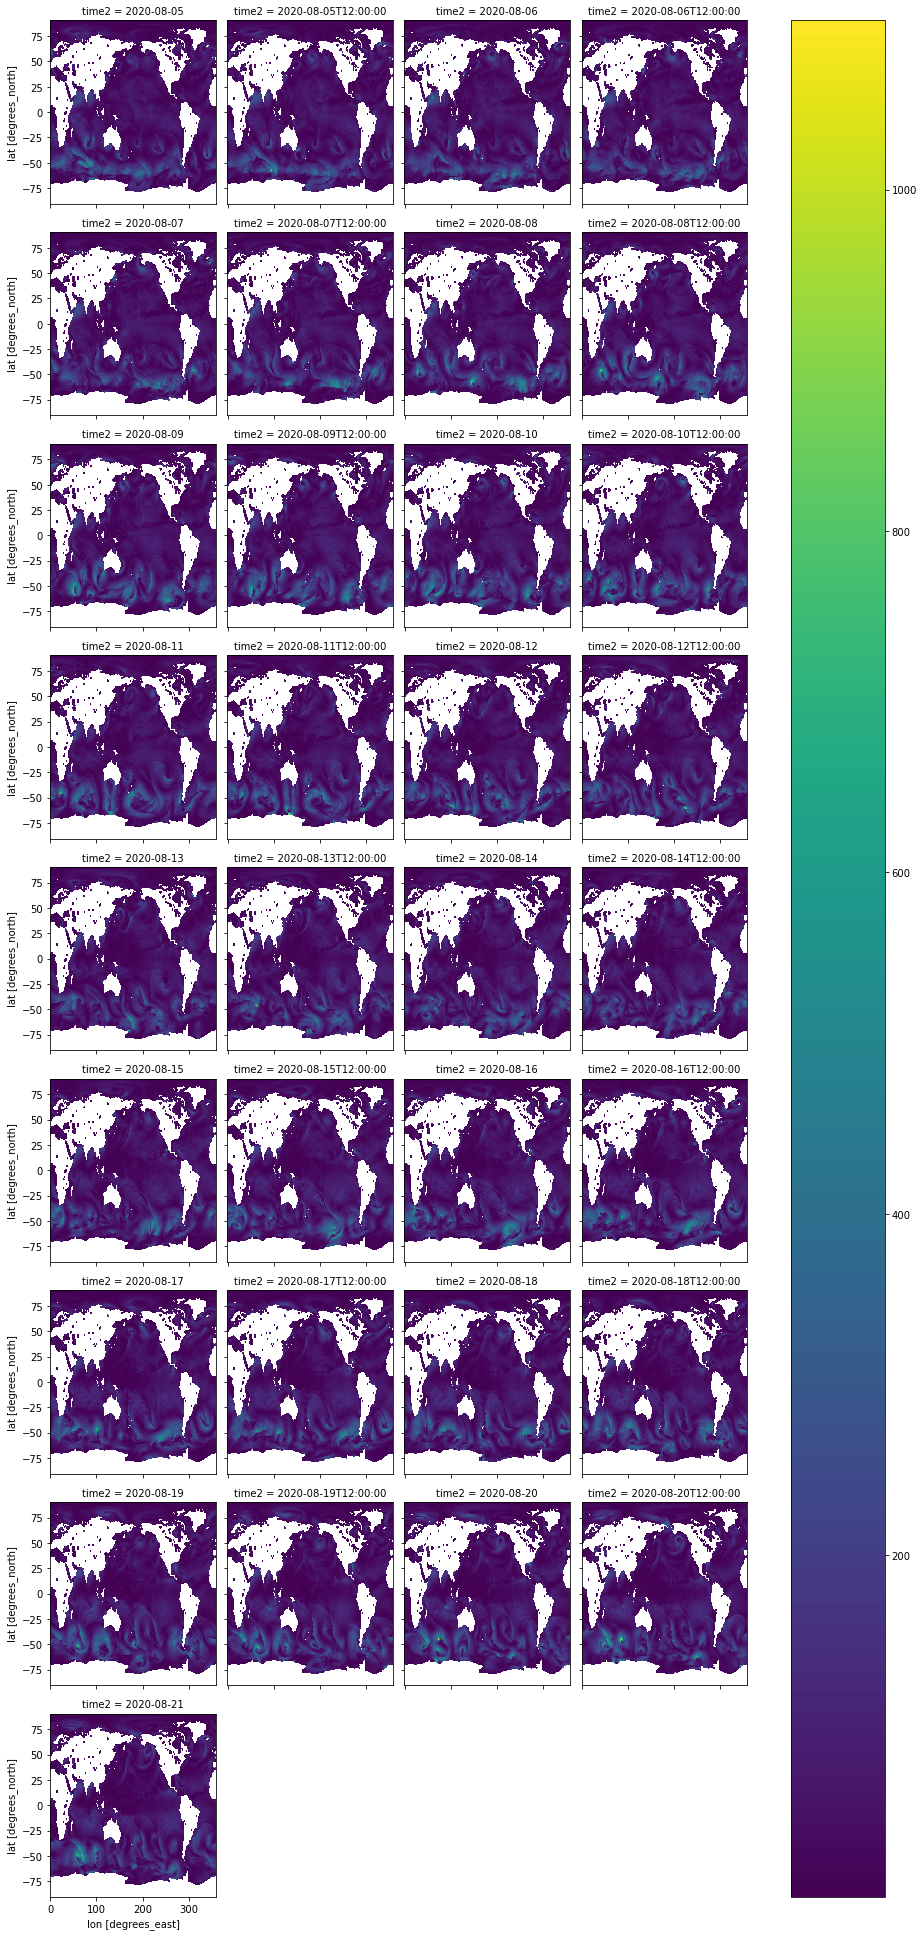

In [12]:
speed.isel(time2=slice(0, None, 4)).plot(
    col="time2", col_wrap=4
);